# Suscripción de datos de mercado de Binance en vivo con websockets

Este cuaderno muestra como consumir datos en vivo con [Unicorn Binanace Websocket API](https://github.com/LUCIT-Systems-and-Development/unicorn-binance-websocket-api)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!pip install unicorn-binance-websocket-api --upgrade
!pip list | grep unicorn-binance-websocket-api

unicorn-binance-websocket-api      1.41.0


In [4]:
import json
import os

SECRETS_FILE="../secrets.json"
assert os.path.exists(SECRETS_FILE), "Se debe proveer un archivo JSON con los parámetros de conexión a la API de Binance"
with open(SECRETS_FILE,"r") as fp:
    secrets = json.load(fp)

## Manejador de eventos de cambio de precio

El siguiente ejemplo muestra un manejador de eventos "dummy" que sólo almacena el valor actual de un activo e imprime la tasa de cambio respecto al valor anterior.

Nota: el código fuente de `BinanceAssetPriceMonitor` y `UserEventHandler` están en [binance_monitor.py](./binance_monitor.py).

In [13]:
import pandas as pd
import time
from binance_monitor import BinanceAssetPriceMonitor, UserEventHandler

class MyTradingMonitor(UserEventHandler):
    
    def __init__(self):
        self.last_price = None
        self.history = []
    
    def price_changed_event(self, symbol, timestamp, price):
        timestamp_arg = pd.to_datetime(timestamp, unit='ms', utc=True) - pd.Timedelta(hours=3)
        
        if self.last_price is None:
            change_rate = 0 
        else:
            change_rate = ((price-self.last_price)/self.last_price)*100.
        self.last_price = price
        
        print(f"{timestamp_arg}: Cambio de precio para {symbol}. Precio actual: {price} ({change_rate:+.2f}%)")        
        self.history.append((timestamp_arg,price))

    def get_history(self):
        return self.history

In [19]:
my_event_handler = MyTradingMonitor()

SYMBOL = "BTCUSDT"
LIVE_MONITORING_INTERVAL_IN_SECONDS = 60

monitor = BinanceAssetPriceMonitor(
    secrets["binance"]["api_key"],
    secrets["binance"]["secret_key"],
    [SYMBOL],
    my_event_handler)

print("Iniciando monitoreo.")
monitor.start()
print(f"Monitoreando por {LIVE_MONITORING_INTERVAL_IN_SECONDS} segundos.")
time.sleep(LIVE_MONITORING_INTERVAL_IN_SECONDS)
print("Finalizando monitoreo")
monitor.stop()

Iniciando monitoreo.
Monitoreando por 60 segundos.
2022-07-03 22:37:58.507000+00:00: Cambio de precio para BTCUSDT. Precio actual: 19168.55 (+0.00%)
2022-07-03 22:38:03.066000+00:00: Cambio de precio para BTCUSDT. Precio actual: 19175.39 (+0.04%)
2022-07-03 22:38:03.760000+00:00: Cambio de precio para BTCUSDT. Precio actual: 19165.51 (-0.05%)
Finalizando monitoreo


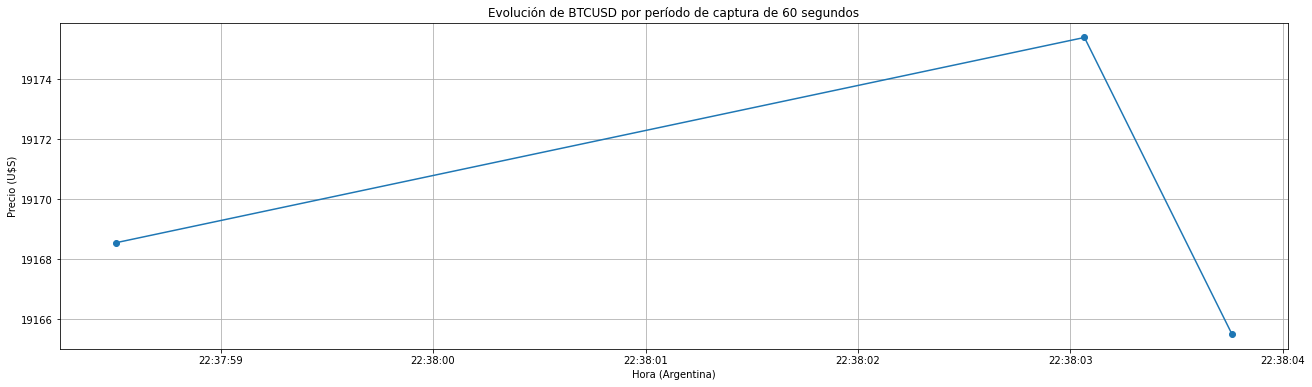

In [23]:
import matplotlib.pyplot as plt
import numpy as np

history = np.array(my_event_handler.get_history())

fig,axes = plt.subplots(1,1,figsize=(22,6))
axes.plot(history[:,0],history[:,1])
axes.scatter(history[:,0],history[:,1])
axes.set_xlabel("Hora (Argentina)")
axes.set_ylabel("Precio (U$S)")
axes.grid(which="Both")
axes.set_title(f"Evolución de BTCUSD por período de captura de {LIVE_MONITORING_INTERVAL_IN_SECONDS} segundos");